In [1]:
from synthcity.plugins import Plugins
from synthcity.utils.serialization import save_to_file, load_from_file
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import pandas as pd

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [3]:
def train_models(gen_list, datasets, n_runs):
    for g in gen_list:
        for dataset in datasets:
            for i in range(n_runs):
                model = Plugins().get(g)
                model.fit(datasets[dataset])
                fp = 'models/' + g + '_' + dataset + '_' + str(i)
                save_to_file(fp, model)

In [4]:
gen_list = Plugins(categories=["generic"]).list()

[2024-04-11T13:34:32.746799+1000][16002][CRITICAL] load failed: 
GReaT is not installed. Please install it with pip install GReaT.
Please be aware that GReaT is only available for python >= 3.9.

[2024-04-11T13:34:32.747990+1000][16002][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2024-04-11T13:34:32.748445+1000][16002][CRITICAL] module plugin_great load failed
[2024-04-11T13:34:32.764931+1000][16002][CRITICAL] module disabled: /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


In [5]:
datasets = {}

In [6]:
ihdp = pd.read_csv('../Datasets/ihdp.csv')

In [31]:
jobs =pd.read_csv('../Datasets/jobs_small.csv')

In [8]:
twins = pd.read_csv('../Datasets/twins.csv')

In [9]:
ihdp

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,True,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,False,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,False,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,False,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,False,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,False,4.091946,6.061976,3.986826,7.053195,-0.007654,-0.202946,-0.360898,0.161703,-0.316603,...,1,0,1,0,0,0,0,0,0,0
743,True,5.501677,4.237157,4.111877,7.084080,0.727295,-0.202946,-0.733261,-0.879606,0.808706,...,1,1,1,0,0,0,0,0,0,0
744,False,1.842583,4.949537,2.346736,6.523225,1.181234,0.196818,-1.477987,0.161703,0.746189,...,1,1,1,0,0,0,0,0,0,0
745,False,3.076368,7.554212,2.114661,6.419095,-0.288664,-0.202946,-1.477987,-0.879606,1.621430,...,1,1,1,0,0,0,0,0,0,0


In [32]:
jobs

,training,age,education,black,hispanic,married,no_degree,re75,re78
0,0.0,19.0,9.0,1.0,0.0,1.0,1.0,0.0000,16658.250
1,0.0,33.0,11.0,1.0,0.0,0.0,1.0,0.0000,0.000
2,0.0,25.0,10.0,1.0,0.0,1.0,1.0,0.0000,0.000
3,1.0,48.0,4.0,1.0,0.0,0.0,1.0,0.0000,6551.592
4,0.0,54.0,11.0,1.0,0.0,0.0,1.0,0.0000,7812.522
...,...,...,...,...,...,...,...,...,...
717,1.0,45.0,5.0,1.0,0.0,1.0,1.0,0.0000,8546.715
718,1.0,19.0,10.0,1.0,0.0,0.0,1.0,385.2741,8124.715
719,1.0,26.0,12.0,1.0,0.0,1.0,0.0,5794.8310,1424.944
720,0.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0000,11197.340


In [11]:
twins

,Unnamed: 0,pldel,birattnd,brstate,stoccfipb,mager8,ormoth,mrace,meduc6,dmar,...,infant_id,dlivord_min,dtotord_min,bord,brstate_reg,stoccfipb_reg,mplbir_reg,wt,treatment,outcome
0,0,1.0,1.0,1.0,1.0,3.0,0.0,1.0,3.0,1.0,...,35.0,3.0,3.0,2.0,5.0,5.0,5.0,936.0,0,0.0
1,1,1.0,1.0,1.0,1.0,3.0,0.0,1.0,3.0,1.0,...,34.0,3.0,3.0,1.0,5.0,5.0,5.0,1006.0,1,0.0
2,2,1.0,1.0,1.0,1.0,3.0,0.0,1.0,2.0,0.0,...,47.0,NaN,NaN,NaN,5.0,5.0,5.0,737.0,0,0.0
3,3,1.0,1.0,1.0,1.0,3.0,0.0,1.0,2.0,0.0,...,46.0,NaN,NaN,NaN,5.0,5.0,5.0,850.0,1,1.0
4,4,1.0,1.0,1.0,1.0,3.0,0.0,1.0,3.0,1.0,...,52.0,1.0,1.0,1.0,5.0,5.0,5.0,1830.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23963,23963,1.0,1.0,50.0,55.0,3.0,0.0,1.0,3.0,1.0,...,278947.0,1.0,2.0,2.0,2.0,2.0,2.0,1758.0,1,0.0
23964,23964,1.0,1.0,50.0,55.0,6.0,0.0,1.0,5.0,1.0,...,278952.0,3.0,3.0,1.0,2.0,2.0,8.0,1616.0,0,0.0
23965,23965,1.0,1.0,50.0,55.0,6.0,0.0,1.0,5.0,1.0,...,278953.0,3.0,3.0,2.0,2.0,2.0,8.0,1814.0,1,0.0
23966,23966,1.0,2.0,51.0,56.0,4.0,0.0,1.0,4.0,1.0,...,279010.0,1.0,1.0,1.0,7.0,7.0,3.0,936.0,0,1.0


In [41]:
ctgan = Plugins().get('ctgan')

[2024-04-11T13:59:48.501111+1000][16002][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2024-04-11T13:59:48.502236+1000][16002][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2024-04-11T13:59:48.502950+1000][16002][CRITICAL] module plugin_great load failed
[2024-04-11T13:59:48.504012+1000][16002][CRITICAL] module disabled: /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/synthcity/plugins/generic/plugin_goggle.py


In [42]:
ctgan.fit(jobs)

 27%|██▋       | 549/2000 [02:59<07:55,  3.05it/s]


In [43]:
s = ctgan.generate(count = 722)

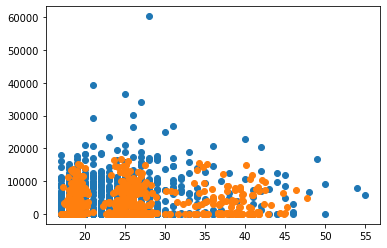

In [44]:
plt.scatter(jobs['age'], jobs['re78'])
plt.scatter(s['age'], s['re78'])

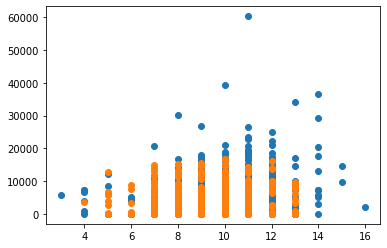

In [45]:
plt.scatter(jobs['education'], jobs['re78'])
plt.scatter(s['education'], s['re78'])

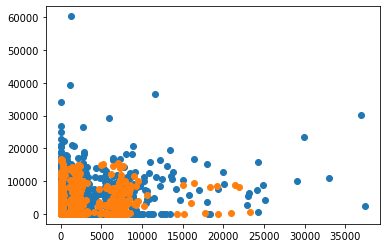

In [46]:
plt.scatter(jobs['re75'], jobs['re78'])
plt.scatter(s['re75'], s['re78'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fed4e267c10>,
 'caps': [<matplotlib.lines.Line2D at 0x7fed4e274310>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fed4e2678b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fed4e2749d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fed4e274cd0>],
 'means': []}

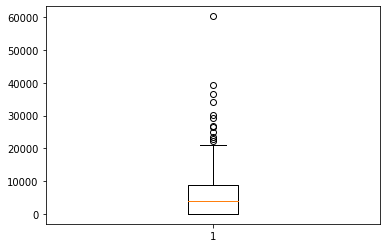

In [27]:
plt.boxplot(jobs['re78'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fed4d88a9d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fed4d896070>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fed4d88a640>],
 'medians': [<matplotlib.lines.Line2D at 0x7fed4d896790>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fed4d896a90>],
 'means': []}

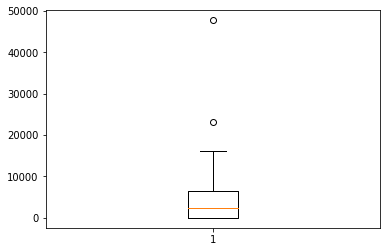

In [26]:
plt.boxplot(s['re78'])

In [28]:
jobs[jobs['black']==1]

,Unnamed: 0,training,age,education,black,hispanic,married,no_degree,re75,re78
0,336,0.0,19.0,9.0,1.0,0.0,1.0,1.0,0.0000,16658.250
1,516,0.0,33.0,11.0,1.0,0.0,0.0,1.0,0.0000,0.000
2,552,0.0,25.0,10.0,1.0,0.0,1.0,1.0,0.0000,0.000
3,33,1.0,48.0,4.0,1.0,0.0,0.0,1.0,0.0000,6551.592
4,558,0.0,54.0,11.0,1.0,0.0,0.0,1.0,0.0000,7812.522
...,...,...,...,...,...,...,...,...,...,...
717,71,1.0,45.0,5.0,1.0,0.0,1.0,1.0,0.0000,8546.715
718,106,1.0,19.0,10.0,1.0,0.0,0.0,1.0,385.2741,8124.715
719,270,1.0,26.0,12.0,1.0,0.0,1.0,0.0,5794.8310,1424.944
720,435,0.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0000,11197.340


In [47]:
jobs

,training,age,education,black,hispanic,married,no_degree,re75,re78
0,0.0,19.0,9.0,1.0,0.0,1.0,1.0,0.0000,16658.250
1,0.0,33.0,11.0,1.0,0.0,0.0,1.0,0.0000,0.000
2,0.0,25.0,10.0,1.0,0.0,1.0,1.0,0.0000,0.000
3,1.0,48.0,4.0,1.0,0.0,0.0,1.0,0.0000,6551.592
4,0.0,54.0,11.0,1.0,0.0,0.0,1.0,0.0000,7812.522
...,...,...,...,...,...,...,...,...,...
717,1.0,45.0,5.0,1.0,0.0,1.0,1.0,0.0000,8546.715
718,1.0,19.0,10.0,1.0,0.0,0.0,1.0,385.2741,8124.715
719,1.0,26.0,12.0,1.0,0.0,1.0,0.0,5794.8310,1424.944
720,0.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0000,11197.340


In [67]:
jobs.groupby(['black', 'married', 'no_degree', 'training']).count()

age  education  hispanic  re75  re78
black married no_degree training                                      
0.0   0.0     0.0       0.0        16         16        16    16    16
                        1.0        13         13        13    13    13
              1.0       0.0        57         57        57    57    57
                        1.0        36         36        36    36    36
      1.0     0.0       0.0         2          2         2     2     2
                        1.0         5          5         5     5     5
              1.0       0.0        10         10        10    10    10
                        1.0         5          5         5     5     5
1.0   0.0     0.0       0.0        49         49        49    49    49
                        1.0        54         54        54    54    54
              1.0       0.0       236        236       236   236   236
                        1.0       144        144       144   144   144
      1.0     0.0       0.0        12         12        12    12    12
                        1.0         8          8         8     8     8
              1.0       0.0        43         43        43    43    43
                        1.0        32         32        32    32    32

In [70]:
s.dataframe().groupby(['black', 'married', 'no_degree', 'training']).count()

age  education  hispanic  re75  re78
black married no_degree training                                      
0.0   0.0     0.0       0.0        14         14        14    14    14
                        1.0         4          4         4     4     4
              1.0       0.0        51         51        51    51    51
                        1.0        42         42        42    42    42
      1.0     0.0       0.0         1          1         1     1     1
              1.0       0.0        10         10        10    10    10
                        1.0         7          7         7     7     7
1.0   0.0     0.0       0.0        36         36        36    36    36
                        1.0        51         51        51    51    51
              1.0       0.0       238        238       238   238   238
                        1.0       181        181       181   181   181
      1.0     0.0       0.0        10         10        10    10    10
                        1.0         9          9         9     9     9
              1.0       0.0        48         48        48    48    48
                        1.0        20         20        20    20    20